# Import Libreries and Load Data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
raw_weekly_data_ = pd.read_csv('drive/MyDrive/datasets/CC/LTC/weekly_LTC')
raw_weekly_data_.shape

(268, 7)

(267,)


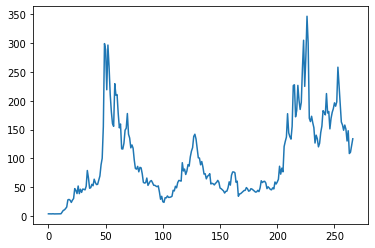

In [ ]:
last_index = raw_weekly_data_.shape[0] - 1
LTC_weekly = raw_weekly_data_['Close'].drop(index = last_index, axis = 0)
print(LTC_weekly.shape)
plt.plot(LTC_weekly)

# Weekly Analysis

## Splitting

In [ ]:
# set intervals for train, val and test sets

a = 110
b = 230

train_set = LTC_weekly[0:a]
val_set = LTC_weekly[a:b]
test_set = LTC_weekly[b:last_index]

mean = LTC_weekly[0:a].mean()
std = LTC_weekly[0:a].std()

train_set = (train_set - mean) / std
val_set = (val_set - mean) / std
test_set = (test_set - mean) / std

train_set.shape, val_set.shape, test_set.shape

((110,), (120,), (37,))

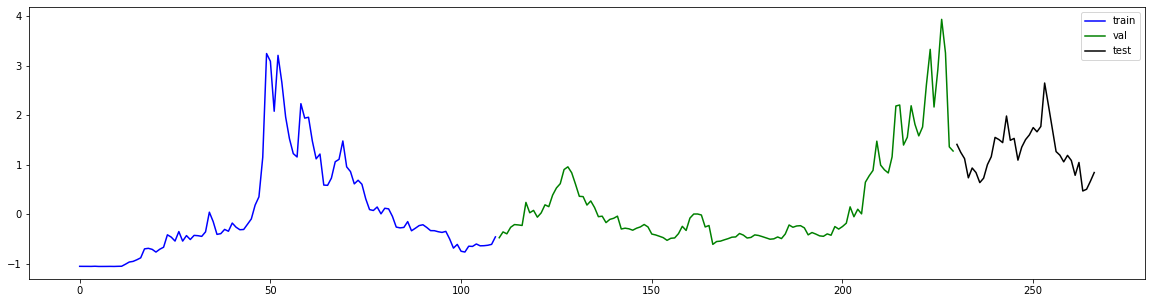

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(train_set, 'b-', label = 'train');
plt.plot(range(a, b), val_set, 'g-', label = 'val');
plt.plot(range(b, last_index), test_set, 'k-', label = 'test');
plt.legend();

In [ ]:
time_step = 6
values_to_predict = 1

def create_set(set_):

    X = []
    Y = []

    for i in range(len(set_) - time_step - values_to_predict):
        data_in_one_time_step = set_[i : i+time_step]
        next_one = set_[i+time_step: i+time_step+values_to_predict]
        X.append(data_in_one_time_step)
        Y.append(next_one)

    X = np.array(X).reshape(-1, time_step, 1)
    Y = np.array(Y)
    
    return X, Y

In [ ]:
X_train, Y_train = create_set(train_set)
X_val, Y_val = create_set(val_set)
X_test, Y_test = create_set(test_set)
print('Train set shape:', X_train.shape, Y_train.shape)
print('Val set shape:', X_val.shape, Y_val.shape)
print('Test set shape:', X_test.shape, Y_test.shape)

Train set shape: (103, 6, 1) (103, 1)
Val set shape: (113, 6, 1) (113, 1)
Test set shape: (30, 6, 1) (30, 1)


## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Conv1D, TimeDistributed, BatchNormalization, SimpleRNN

weekly_model = tf.keras.models.Sequential([Conv1D(filters = 1, kernel_size = 1, input_shape = [None, 1]),
                                           GRU(16),
                                           Dropout(0.2),
                                           Dense(values_to_predict)
])

weekly_model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adadelta(lr = 0.8),
                     )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 400),
            tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 100, monitor = 'val_loss'),
            tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/datasets/CC/LTC/weekly_model.h5', 
                                               save_best_only = True)]

In [ ]:
history = weekly_model.fit(X_train, Y_train, 
                         validation_data = (X_val, Y_val),
                         epochs = 3000, batch_size = 32,
                         callbacks = callbacks)

Epoch 1/3000
4/4 [==============================] - 5s 237ms/step - loss: 2.3967 - val_loss: 2.2022 - lr: 0.8000
Epoch 2/3000
4/4 [==============================] - 0s 29ms/step - loss: 2.3473 - val_loss: 2.0857 - lr: 0.8000
Epoch 3/3000
4/4 [==============================] - 0s 33ms/step - loss: 2.1277 - val_loss: 1.9659 - lr: 0.8000
Epoch 4/3000
4/4 [==============================] - 0s 29ms/step - loss: 2.1568 - val_loss: 1.8467 - lr: 0.8000
Epoch 5/3000
4/4 [==============================] - 0s 26ms/step - loss: 1.9697 - val_loss: 1.7653 - lr: 0.8000
Epoch 6/3000
4/4 [==============================] - 0s 30ms/step - loss: 1.8272 - val_loss: 1.6758 - lr: 0.8000
Epoch 7/3000
4/4 [==============================] - 0s 27ms/step - loss: 1.8629 - val_loss: 1.5523 - lr: 0.8000
Epoch 8/3000
4/4 [==============================] - 0s 31ms/step - loss: 1.6388 - val_loss: 1.4760 - lr: 0.8000
Epoch 9/3000
4/4 [==============================] - 0s 27ms/step - loss: 1.5847 - val_loss: 1.3729 - lr

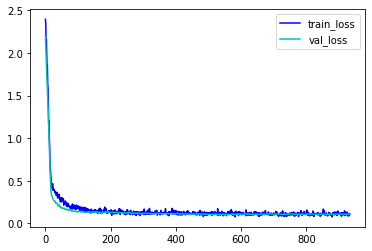

In [ ]:
plt.plot(history.history['loss'], 'b-', label = 'train_loss')
plt.plot(history.history['val_loss'], 'c-', label = 'val_loss')
plt.legend()

## Testing

In [ ]:
weekly_model = tf.keras.models.load_model('drive/MyDrive/datasets/CC/LTC/weekly_model.h5')

In [ ]:
y_val_pred = weekly_model.predict(X_val)
y_test_pred = weekly_model.predict(X_test)
y_val_pred.shape, y_test_pred.shape

((113, 1), (30, 1))

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, y_test_pred[:, 0])

0.09278870913908405

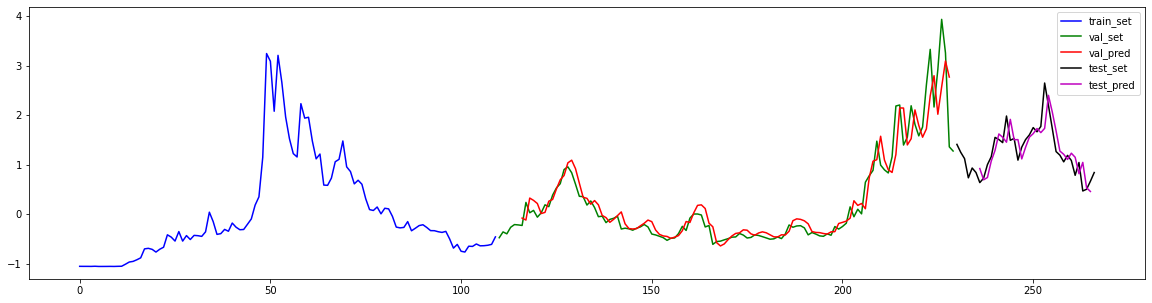

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(train_set, 'b-', label = 'train_set');
plt.plot(range(a, b), val_set, 'g-', label = 'val_set');
plt.plot(range(a+time_step, a+y_val_pred.shape[0]+time_step), y_val_pred[:, 0], 'r-', label = 'val_pred');
plt.plot(range(b, last_index), test_set, 'k-', label = 'test_set');
plt.plot(range(b+time_step, b+y_test_pred.shape[0]+time_step), y_test_pred[:, 0], 'm-', label = 'test_pred');
plt.legend();

## Prediction

In [ ]:
def prediction_accuracy(X, set_):

    num_predictions = set_.shape[0] - time_step - 1
    table = []

    for i in range(num_predictions):

        last_value = np.array(set_)[i+time_step-1] * std + mean
        predicted_value = weekly_model.predict(X[i].reshape(1, time_step, 1))[0][0] * std + mean
        actual_value = np.array(set_)[i+time_step] * std + mean
        predicted_change_rate = (predicted_value - last_value) / last_value
        actual_change_rate = (actual_value - last_value) / last_value

        if (predicted_value > last_value and actual_value > last_value) == True:
            prediction_result = 1
        elif (predicted_value < last_value and actual_value < last_value) == True:
            prediction_result = 1
        else:
            prediction_result = 0
        table.append([last_value, predicted_value, actual_value, predicted_change_rate, actual_change_rate, prediction_result])

    table = np.array(table)
    table = pd.DataFrame(data = table, columns = ['last_value', 'predicted_value', 'actual_value', 
                                                  'predicted_change_rate', 'actual_change_rate', 'prediction_result'])
    accuracy = sum(table['prediction_result']) / num_predictions

    return table, accuracy

In [ ]:
train_table, train_accuracy = prediction_accuracy(X_train, train_set)
val_table, val_accuracy = prediction_accuracy(X_val, val_set)
test_table, test_accuracy = prediction_accuracy(X_test, test_set)

print('Train_accuracy:', train_accuracy, 'Val_accuracy:', val_accuracy, 'Test_accuracy:', test_accuracy)

Train_accuracy: 0.47572815533980584 Val_accuracy: 0.5752212389380531 Test_accuracy: 0.6


In [ ]:
def accuracy_with_change_rate(table_set, expected_change_rate):
    table = table_set[abs(table_set['predicted_change_rate']) > expected_change_rate]
    accuracy = sum(np.array(table['prediction_result'])) / len(table)
    return accuracy

In [ ]:
accuracy_with_change_rate(test_table, 0.03)

0.8571428571428571

In [ ]:
test_table[abs(test_table['predicted_change_rate']) > 0.03]

,last_value,predicted_value,actual_value,predicted_change_rate,actual_change_rate,prediction_result
0,133.987289,139.532493,120.027077,0.041386,-0.104191,0.0
1,120.027077,123.892875,126.188675,0.032208,0.051335,1.0
3,144.933212,149.840483,155.864777,0.033859,0.075425,1.0
4,155.864777,164.789921,182.711273,0.057262,0.172242,1.0
18,258.093201,240.992902,227.079605,-0.066256,-0.120164,1.0
19,227.079605,217.999194,195.174423,-0.039988,-0.140502,1.0
28,108.428497,112.856361,110.823677,0.040837,0.022090,1.0


In [ ]:
last_series = np.array(test_set)[-time_step:].reshape(1, time_step, 1)
several_values_ahead = []
for i in range(4):
    next_value = weekly_model.predict(last_series) * std + mean
    next_series = np.concatenate((last_series[0, :, 0], next_value[0]), axis = 0)
    last_series = next_series[-time_step:].reshape(1, time_step, 1)
    several_values_ahead.append(next_value[0][0])

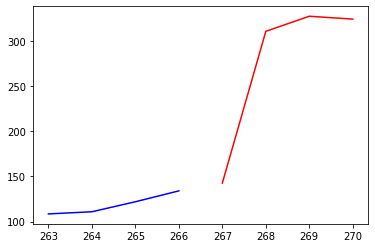

In [ ]:
plt.plot(test_set[-4:] * std + mean, 'b-')
plt.plot(range(last_index, last_index+4), several_values_ahead, 'r-')

In [ ]:
weekly_model.predict(np.array(test_set)[-time_step:].reshape(1, time_step, 1)) * std + mean

array([[135.19446]], dtype=float32)

In [ ]:
(several_values_ahead) 

[135.19446, 345.0644, 345.6536, 346.06293]

# Daily Analysis



```
tf.keras.utils.get_file(origin = 'https://query1.finance.yahoo.com/v7/finance/download/LTC-USD?period1=1483228800&period2=1644796800&interval=1d&events=history&includeAdjustedClose=true',
                        fname = 'daily_LTC',
                        cache_dir = 'drive/MyDrive',
                        cache_subdir = 'datasets/CC/LTC')
```



In [ ]:
LTC_daily = pd.read_csv('drive/MyDrive/datasets/CC/LTC/daily_LTC')
LTC_daily = LTC_daily['Close']
LTC_daily.shape

(1871,)

## Splitting

In [ ]:
# set intervals for train, val and test sets

last_index = LTC_daily.shape[0]
a = 1100
b = 1500

train_set = LTC_daily[0:a]
val_set = LTC_daily[a:b]
test_set = LTC_daily[b:last_index]

mean = LTC_daily[0:a].mean()
std = LTC_daily[0:a].std()

train_set = (train_set - mean) / std
val_set = (val_set - mean) / std
test_set = (test_set - mean) / std

train_set.shape, val_set.shape, test_set.shape

((1100,), (400,), (371,))

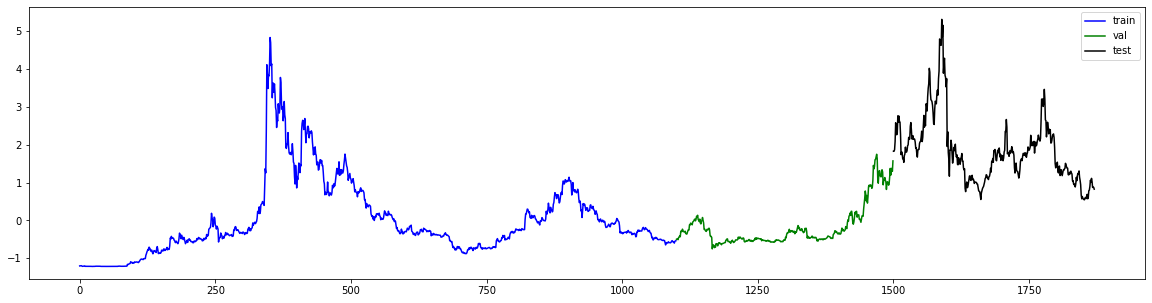

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(train_set, 'b-', label = 'train');
plt.plot(range(a, b), val_set, 'g-', label = 'val');
plt.plot(range(b, last_index), test_set, 'k-', label = 'test');
plt.legend();

In [ ]:
time_step = 4
values_to_predict = 1

def create_set(set_):

    X = []
    Y = []

    for i in range(len(set_) - time_step - values_to_predict):
        data_in_one_time_step = set_[i : i+time_step]
        next_one = set_[i+time_step: i+time_step+values_to_predict]
        X.append(data_in_one_time_step)
        Y.append(next_one)

    X = np.array(X).reshape(-1, time_step, 1)
    Y = np.array(Y)
    
    return X, Y

In [ ]:
X_train, Y_train = create_set(train_set)
X_val, Y_val = create_set(val_set)
X_test, Y_test = create_set(test_set)
print('Train set shape:', X_train.shape, Y_train.shape)
print('Val set shape:', X_val.shape, Y_val.shape)
print('Test set shape:', X_test.shape, Y_test.shape)

Train set shape: (1095, 4, 1) (1095, 1)
Val set shape: (395, 4, 1) (395, 1)
Test set shape: (366, 4, 1) (366, 1)


## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Conv1D, TimeDistributed, BatchNormalization, SimpleRNN

daily_model = tf.keras.models.Sequential([Conv1D(filters = 16, kernel_size = 1, input_shape = [None, 1]),
                                          BatchNormalization(),
                                          LSTM(16, return_sequences = True),
                                          BatchNormalization(),
                                          LSTM(16),
                                          #Dropout(0.),
                                          Dense(values_to_predict)
])

daily_model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adadelta(lr = 0.4),
                     )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 400),
            tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 100, monitor = 'val_loss'),
            tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/datasets/CC/LTC/daily_model.h5', 
                                               save_best_only = True)]

In [ ]:
history = daily_model.fit(X_train, Y_train, 
                         validation_data = (X_val, Y_val),
                         epochs = 3000, batch_size = 64,
                         callbacks = callbacks)

Epoch 1/3000
18/18 [==============================] - 6s 69ms/step - loss: 0.5211 - val_loss: 0.2644 - lr: 0.4000
Epoch 2/3000
18/18 [==============================] - 0s 13ms/step - loss: 0.2091 - val_loss: 0.2631 - lr: 0.4000
Epoch 3/3000
18/18 [==============================] - 0s 10ms/step - loss: 0.1417 - val_loss: 0.2698 - lr: 0.4000
Epoch 4/3000
18/18 [==============================] - 0s 9ms/step - loss: 0.1017 - val_loss: 0.2790 - lr: 0.4000
Epoch 5/3000
18/18 [==============================] - 0s 9ms/step - loss: 0.0824 - val_loss: 0.2830 - lr: 0.4000
Epoch 6/3000
18/18 [==============================] - 0s 10ms/step - loss: 0.0950 - val_loss: 0.2747 - lr: 0.4000
Epoch 7/3000
18/18 [==============================] - 0s 10ms/step - loss: 0.0780 - val_loss: 0.2793 - lr: 0.4000
Epoch 8/3000
18/18 [==============================] - 0s 11ms/step - loss: 0.0706 - val_loss: 0.2642 - lr: 0.4000
Epoch 9/3000
18/18 [==============================] - 0s 13ms/step - loss: 0.0800 - val_lo

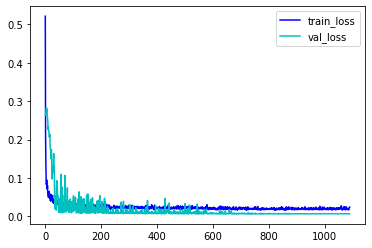

In [ ]:
plt.plot(history.history['loss'], 'b-', label = 'train_loss')
plt.plot(history.history['val_loss'], 'c-', label = 'val_loss')
plt.legend()

## Testing

In [ ]:
daily_model = tf.keras.models.load_model('drive/MyDrive/datasets/CC/LTC/daily_model.h5')

In [ ]:
y_val_pred = daily_model.predict(X_val)
y_test_pred = daily_model.predict(X_test)
y_val_pred.shape, y_test_pred.shape

((395, 1), (366, 1))

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, y_test_pred[:, 0])

0.05726705109490356

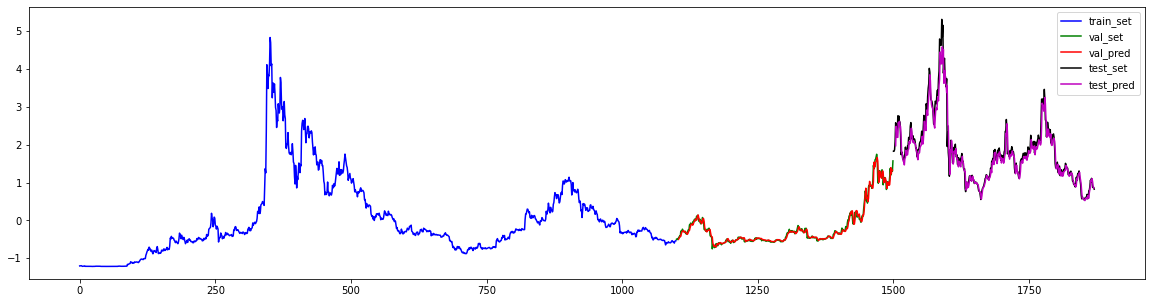

In [ ]:
plt.figure(figsize = (20, 5))
plt.plot(train_set, 'b-', label = 'train_set');
plt.plot(range(a, b), val_set, 'g-', label = 'val_set');
plt.plot(range(a+time_step, a+y_val_pred.shape[0]+time_step), y_val_pred[:, 0], 'r-', label = 'val_pred');
plt.plot(range(b, last_index), test_set, 'k-', label = 'test_set');
plt.plot(range(b+time_step, b+y_test_pred.shape[0]+time_step), y_test_pred[:, 0], 'm-', label = 'test_pred');
plt.legend();

## Prediction

In [ ]:
def prediction_accuracy(X, set_):

    num_predictions = set_.shape[0] - time_step - 1
    table = []

    for i in range(num_predictions):

        last_value = np.array(set_)[i+time_step-1] * std + mean
        predicted_value = daily_model.predict(X[i].reshape(1, time_step, 1))[0][0] * std + mean
        actual_value = np.array(set_)[i+time_step] * std + mean
        predicted_change_rate = (predicted_value - last_value) / last_value
        actual_change_rate = (actual_value - last_value) / last_value

        if (predicted_value > last_value and actual_value > last_value) == True:
            prediction_result = 1
        elif (predicted_value < last_value and actual_value < last_value) == True:
            prediction_result = 1
        else:
            prediction_result = 0
        table.append([last_value, predicted_value, actual_value, predicted_change_rate, actual_change_rate, prediction_result])

    table = np.array(table)
    table = pd.DataFrame(data = table, columns = ['last_value', 'predicted_value', 'actual_value', 
                                                  'predicted_change_rate', 'actual_change_rate', 'prediction_result'])
    accuracy = sum(table['prediction_result']) / num_predictions

    return table, accuracy

In [ ]:
train_table, train_accuracy = prediction_accuracy(X_train, train_set)
val_table, val_accuracy = prediction_accuracy(X_val, val_set)
test_table, test_accuracy = prediction_accuracy(X_test, test_set)

print('Train_accuracy:', train_accuracy, 'Val_accuracy:', val_accuracy, 'Test_accuracy:', test_accuracy)

Train_accuracy: 0.5333333333333333 Val_accuracy: 0.5164556962025316 Test_accuracy: 0.5136612021857924


In [ ]:
def accuracy_with_change_rate(table_set, expected_change_rate):
    table = table_set[abs(table_set['predicted_change_rate']) > expected_change_rate]
    accuracy = sum(np.array(table['prediction_result'])) / len(table)
    return accuracy

In [ ]:
accuracy_with_change_rate(test_table, 0.15)

1.0

In [ ]:
test_table[abs(test_table['predicted_change_rate']) > 0.15]

,last_value,predicted_value,actual_value,predicted_change_rate,actual_change_rate,prediction_result
96,189.520172,223.134809,212.276138,0.177367,0.120071,1.0


In [ ]:
last_series = np.array(test_set)[-time_step:].reshape(1, time_step, 1)
several_values_ahead = []
for i in range(7):
    next_value = daily_model.predict(last_series) * std + mean
    next_series = np.concatenate((last_series[0, :, 0], next_value[0]), axis = 0)
    last_series = next_series[-time_step:].reshape(1, time_step, 1)
    several_values_ahead.append(next_value[0][0])

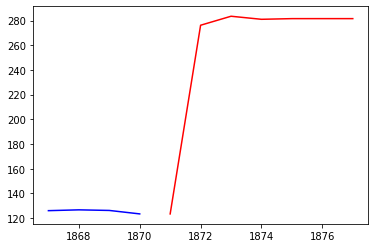

In [ ]:
plt.plot(test_set[-4:] * std + mean, 'b-')
plt.plot(range(last_index, last_index+7), several_values_ahead, 'r-')

In [ ]:
daily_model.predict(np.array(test_set)[-8:].reshape(1, 8, 1)) * std + mean

array([[82.63684]], dtype=float32)

In [ ]:
(several_values_ahead) 

[123.38895, 276.21545, 283.49976, 281.02374, 281.5658, 281.57095, 281.57056]